We use the Microsoft Azure Anomaly Detector service to identify potential anomalies as outliers in the dataset. A tutorial about this service can be found [here](https://docs.microsoft.com/en-us/learn/modules/identify-abnormal-time-series-data-anomaly-detector). Instructions on how to setup the service and install the Python package can be found [here](https://docs.microsoft.com/en-us/azure/cognitive-services/anomaly-detector/quickstarts/client-libraries?pivots=programming-language-python&tabs=windows).

In [1]:
# !pip install azure-ai-anomalydetector --upgrade

Import the necessary packages.

In [2]:
import pandas as pd
import numpy as np

from azure.ai.anomalydetector import AnomalyDetectorClient
from azure.ai.anomalydetector.models import DetectRequest, TimeSeriesPoint, TimeGranularity, AnomalyDetectorError
from azure.core.credentials import AzureKeyCredential

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Read in the data with input and output sensor measurements generated in the previous step.

In [3]:
df_sensors = pd.read_parquet('./data_generated/raw_sensor_data.parquet')

df_sensors

,time,sensor,value
0,0,IN1,0.077744
1,1,IN1,0.080313
2,2,IN1,0.087355
3,3,IN1,0.091774
4,4,IN1,0.091166
...,...,...,...
144005,14396,IN8,-1.713229
144006,14397,IN8,-1.253816
144007,14398,IN8,-1.692019
144008,14399,IN8,-1.242460


Check the number of datapoints available for each sensor. Here we see the difference in counts for the time and value columns, corresponding to the missing values introduced for the input sensor measurements.

In [4]:
sensors_data_length = df_sensors.groupby('sensor').count()
sensors_data_length

,time,value
sensor,,
IN1,14401,14284
IN2,14401,14270
IN3,14401,14281
IN4,14401,14273
IN5,14401,14273
IN6,14401,14273
IN7,14401,14281
IN8,14401,14273
Out1,14401,14401


Here we have the core of our data preparation procedure. We start by running linear interpolation for all input sensors to impute missing values. Then we run the Azure Anomaly Detector service for all input and output sensors to flag anomalies and replace each anomalous data point by a missing value. Finally, we run a second pass of linear interpolation to impute those missing values. At the end of this process, we have our prepared dataset in wide format, indexed by time with measurements by minute.

In [5]:
%%capture --no-display

ANOMALY_DETECTOR_KEY = '<your anomaly detector key>'
ANOMALY_DETECTOR_ENDPOINT = '<your anomaly detector endpoint>'

client = AnomalyDetectorClient(AzureKeyCredential(ANOMALY_DETECTOR_KEY), ANOMALY_DETECTOR_ENDPOINT)

df_sensors_prepared = pd.DataFrame()
idx = pd.date_range(start=0, end=(sensors_data_length.max()['time'] - 1) * 60 * 1e9, freq='T', tz='UTC')
data_length = len(idx)

# max_data_points = 8640
# min_data_points = 12

for sensor in df_sensors['sensor'].unique():
    df_sensor = df_sensors[df_sensors['sensor'] == sensor]
    ts = pd.Series(df_sensor['value'])
    ts.index = idx
    ts = ts.interpolate(limit_direction='both')
    
    batches = [ts[0:int(data_length/2)], ts[int(data_length/2):]]
    responses = []
    for batch in batches:
        series = []
        for index, value in zip(batch.index, batch):
            series.append(TimeSeriesPoint(timestamp=index, value=value))

        request = DetectRequest(series=series, granularity=TimeGranularity.PER_MINUTE, sensitivity=15)
        response = client.detect_entire_series(request)
        responses.append(response)
    
    df_sensor['is_anomaly'] = responses[0].is_anomaly + responses[1].is_anomaly
    df_sensor.reset_index(drop=True, inplace=True)
    df_sensor['new_value'] = df_sensor['value']
    df_sensor.loc[(df_sensor['is_anomaly'] == True), 'new_value'] = np.nan

    ts = pd.Series(df_sensor['new_value'])
    ts.index = idx
    ts = ts.interpolate(limit_direction='both')
    
    df_sensors_prepared[sensor] = ts
    
df_sensors_prepared

,IN1,IN2,IN3,IN4,IN5,Out1,Out2,IN6,IN7,IN8
1970-01-01 00:00:00+00:00,0.077744,0.795565,-0.068312,0.879321,0.134419,-0.122686,0.123661,-0.463482,1.135632,0.191626
1970-01-01 00:01:00+00:00,0.080313,0.824595,-0.068312,0.875636,0.134941,-0.122686,0.123661,-0.998246,1.085583,0.503527
1970-01-01 00:02:00+00:00,0.087355,0.776258,-0.068312,0.884105,0.132452,-0.026857,0.123661,-1.171168,0.096908,-0.133069
1970-01-01 00:03:00+00:00,0.091774,0.739149,-0.068312,0.892043,0.131287,-0.026857,0.251010,0.260074,0.332611,-0.151051
1970-01-01 00:04:00+00:00,0.091166,0.761332,-0.068312,0.892752,0.136788,-0.026857,0.251010,-0.941272,0.324632,-0.260873
...,...,...,...,...,...,...,...,...,...,...
1970-01-10 23:56:00+00:00,-2.371841,-1.399878,-2.594168,-0.861832,-1.607387,-2.039274,-1.531870,-2.462220,-0.748116,-1.713229
1970-01-10 23:57:00+00:00,-2.378745,-1.394332,-2.594168,-0.871577,-1.604817,-2.039274,-1.531870,-2.552222,-1.493226,-1.253816
1970-01-10 23:58:00+00:00,-2.385070,-1.388787,-2.594168,-0.880330,-1.579605,-1.943445,-1.659219,-2.273337,-0.411844,-1.692019
1970-01-10 23:59:00+00:00,-2.386119,-1.372902,-2.594168,-0.886744,-1.556761,-1.943445,-1.659219,-2.517728,-1.720201,-1.242460


Here we plot a segment from the generated measurements for the input sensor IN2 plus its prepared data after missing value imputation and outlier replacement.

Text(0.5, 1.0, 'prepared IN2 measurements')

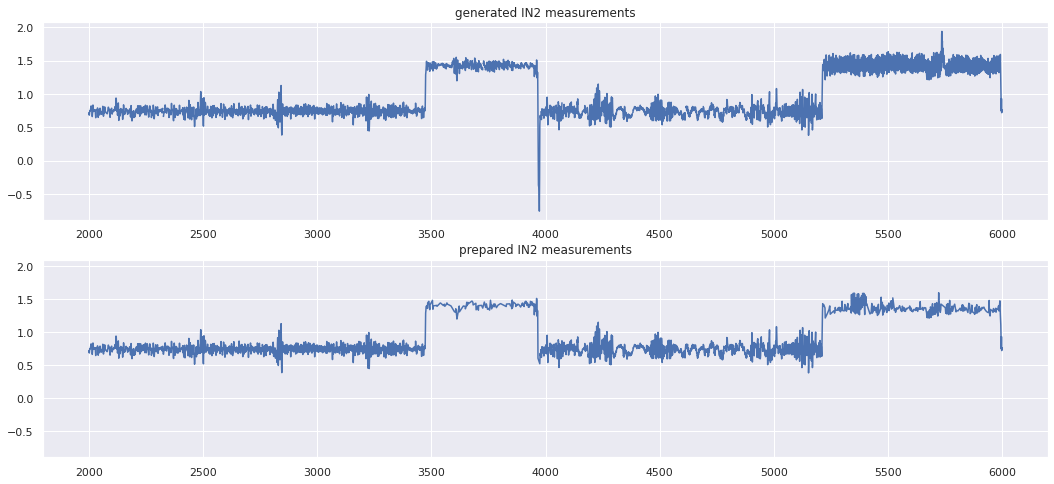

In [6]:
sns.set(rc={'figure.figsize':(18, 8), 'figure.max_open_warning':0})

figure, axis = plt.subplots(2, 1)

plt.ylim(-0.9, 2.1)
axis[0].plot(df_sensors[df_sensors['sensor'] == 'IN2']['value'].reset_index(drop=True)[2000:6000])
axis[0].set_title('generated IN2 measurements')
axis[1].plot(df_sensors_prepared['IN2'].reset_index(drop=True)[2000:6000])
axis[1].set_title('prepared IN2 measurements')

Define a function to compute missing value ratios in a data frame.

In [7]:
def compute_missing_ratio(df):
    df_missing = (df.isnull().sum() / len(df)) * 100
    df_missing = df_missing.drop(df_missing[df_missing == 0].index).sort_values(ascending = False)
    display(pd.DataFrame({'Missing Ratio' :df_missing}))

Check for missing values in the prepared data frame.

In [8]:
compute_missing_ratio(df_sensors_prepared)

,Missing Ratio


Save the prepared dataset as a parquet file.

In [9]:
df_sensors_prepared.to_parquet('./data_prepared/prepared_sensor_data.parquet')